In [1]:
import sys
sys.path.append(".")

# also disable grad to save memory
import torch

DEVICE = torch.device("cpu" if torch.cuda.is_available() else "cpu")

import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF


In [2]:
def load_config(config_path, display=False):
    config = OmegaConf.load(config_path)
    if display:
        print(yaml.dump(OmegaConf.to_container(config)))
    return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
    if is_gumbel:
        model = GumbelVQ(**config.model.params)
    else:
        model = VQModel(**config.model.params)
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
        missing, unexpected = model.load_state_dict(sd, strict=False)
    return model.eval()

def reconstruct_with_vqgan(x, model):
    # could also use model(x) for reconstruction but use explicit encoding and decoding here
    z, _, [_, _, indices], _ = model.encode(x)
    #print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
    xrec = model.decode(z)
    return xrec

config1024 = load_config("logs/vqgan_imagenet_f16_1024/configs/model.yaml", display=False)
model1024 = load_vqgan(config1024, ckpt_path="logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt").to(DEVICE)
checkpoint = torch.load('vae1024_256km_epoch2', map_location="cpu")
model1024.load_state_dict(checkpoint)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


<All keys matched successfully>

In [3]:
# Define dataset
import torch
import sys
from nuwa_pytorch import VQGanVAE
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print(datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes=time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes=time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs

from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from torchvision.transforms import ToTensor, Compose, CenterCrop
class radarDataset(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 3, pred_number = 6, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = []
        time_list = time_list_obs + time_list_pre
        #print(time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            #image = np.ma.masked_where(image == 65535, image)
            image = image[264:520,242:498]
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            #image = 2*image-1 #normalize to [-1,1]
            output.append(image)
        output = torch.permute(torch.tensor(np.array(output)), (1, 2, 0))
        output = self.transform(np.array(output))
        return output
#root_dir = '/users/hbi/data/RAD_NL25_RAC_MFBS_EM_5min/'
#dataset = radarDataset(root_dir, ["200808031600"], transform = Compose([ToTensor(),CenterCrop(256)]))


In [8]:
# develop dataset
from torch.cuda.amp import autocast
from torch.autograd import Variable
import pandas as pd
root_dir = '/home/hbi/RAD_NL25_RAP_5min/' 

df_train = pd.read_csv('training_Delfland08-14_20.csv', header = None)
event_times = df_train[0].to_list()
dataset_train = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_s = pd.read_csv('training_Delfland08-14.csv', header = None)
event_times = df_train_s[0].to_list()
dataset_train_del = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_test = pd.read_csv('testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
dataset_test = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali = pd.read_csv('validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
dataset_vali = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_train_aa = pd.read_csv('training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
dataset_train_aa = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_dw = pd.read_csv('training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
dataset_train_dw = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

df_train_re = pd.read_csv('training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
dataset_train_re = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))   

data_list = [dataset_train_aa, dataset_train_dw, dataset_train_del, dataset_train_re]
train_aadedwre = torch.utils.data.ConcatDataset(data_list)

print(len(dataset_train), len(dataset_test), len(dataset_vali))
loaders = { 'train' :DataLoader(train_aadedwre, batch_size=1, shuffle=True, num_workers=8),
            'test' :DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size=1, shuffle=False, num_workers=8),
          
          'train_aa5' :DataLoader(dataset_train_aa, batch_size=1, shuffle=False, num_workers=8),
          'train_dw5' :DataLoader(dataset_train_dw, batch_size=1, shuffle=False, num_workers=8),
          'train_del5' :DataLoader(dataset_train_del, batch_size=1, shuffle=True, num_workers=8),
          'train_re5' :DataLoader(dataset_train_re, batch_size=1, shuffle=False, num_workers=8),
          }

32183 3493 3560


MSE: 0.667 MAE: 0.255 PCC: 0.875 
 CSI(1mm): 0.798 CSI(2mm): 0.715 CSI(8mm): 0.304 
 ACC(1mm): 0.956 ACC(2mm): 0.963 ACC(8mm): 0.992 
 FSS(1km): 0.98 FSS(10km): 0.974 FSS(20km): 0.958 FSS(30km): 0.906


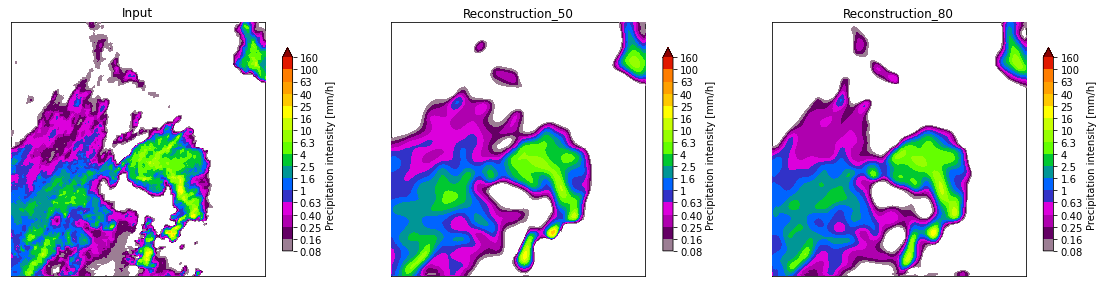

MSE: 0.099 MAE: 0.126 PCC: 0.914 
 CSI(1mm): 0.61 CSI(2mm): 0.575 CSI(8mm): 0.081 
 ACC(1mm): 0.959 ACC(2mm): 0.982 ACC(8mm): 0.999 
 FSS(1km): 0.991 FSS(10km): 0.985 FSS(20km): 0.97 FSS(30km): 0.905


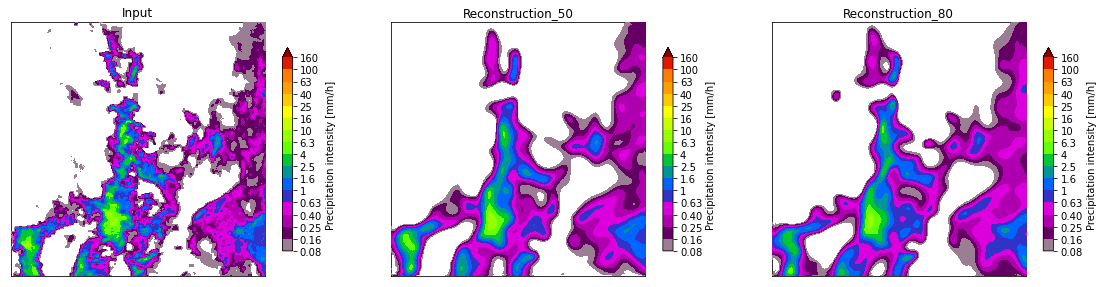

MSE: 0.007 MAE: 0.043 PCC: 0.96 
 CSI(1mm): 0.615 CSI(2mm): nan CSI(8mm): nan 
 ACC(1mm): 0.991 ACC(2mm): 1.0 ACC(8mm): 1.0 
 FSS(1km): 0.986 FSS(10km): 0.98 FSS(20km): 0.968 FSS(30km): 0.919


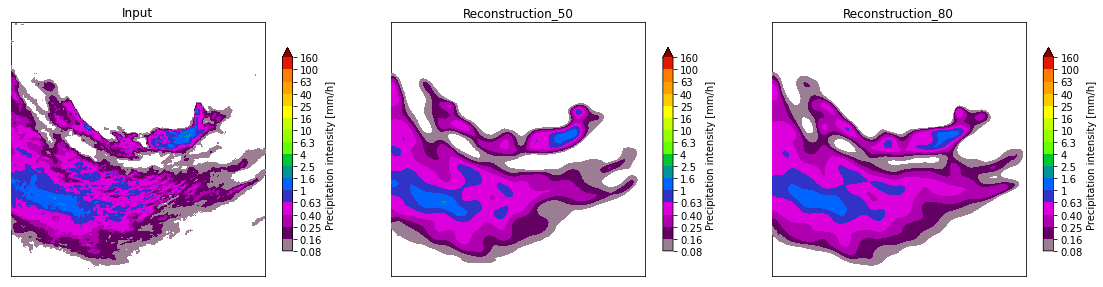

MSE: 4.7 MAE: 0.69 PCC: 0.773 
 CSI(1mm): 0.751 CSI(2mm): 0.643 CSI(8mm): 0.336 
 ACC(1mm): 0.898 ACC(2mm): 0.906 ACC(8mm): 0.976 
 FSS(1km): 0.993 FSS(10km): 0.987 FSS(20km): 0.972 FSS(30km): 0.928


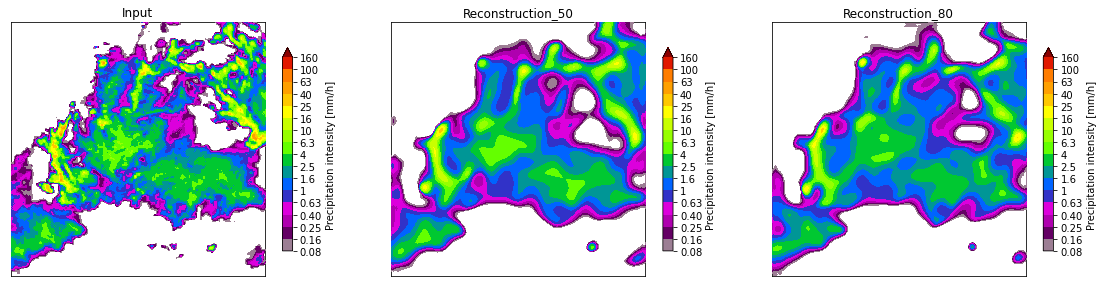

MSE: 0.586 MAE: 0.278 PCC: 0.843 
 CSI(1mm): 0.642 CSI(2mm): 0.554 CSI(8mm): 0.317 
 ACC(1mm): 0.917 ACC(2mm): 0.948 ACC(8mm): 0.996 
 FSS(1km): 0.994 FSS(10km): 0.99 FSS(20km): 0.976 FSS(30km): 0.929


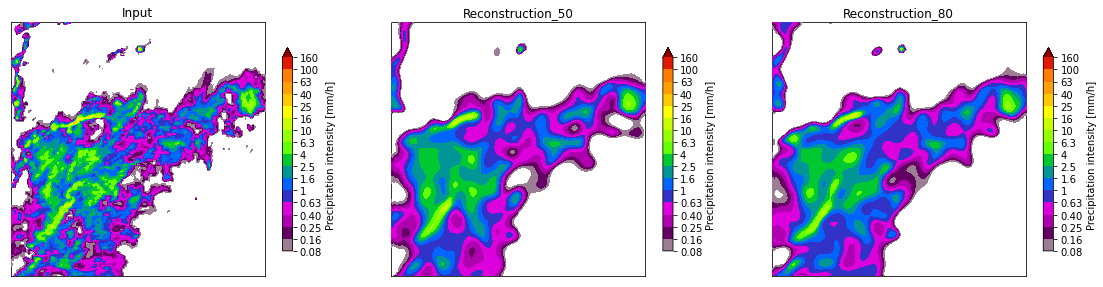

pcc_average: 0.873


In [16]:
#torch.cuda.empty_cache()
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
device = 'cpu'
pcc_average = 0
for i, images in enumerate(loaders['test']):
    if i<0:continue
    if i>=5:break
    for image in images:
        image = image.unsqueeze(1)
        a = Variable(image).to(device)   # batch x
        vae = vae.to(device)
        #model1024 = model1024.to(device)
        a = a[4:5, :, :, :]
        checkpoint = torch.load('/home/hbi/vae_epoch50', map_location = 'cpu')
        vae.load_state_dict(checkpoint, strict=True)
        a_r = vae(a)
        checkpoint = torch.load('/home/hbi/vae_epoch80', map_location = 'cpu')
        vae.load_state_dict(checkpoint, strict=True)
        a_r1 = vae(a)
        #checkpoint = torch.load('/home/hbi/vae_epoch80', map_location = 'cpu')
        #vae.load_state_dict(checkpoint, strict=True)
        #a_r2 = vae(a)

        for t in range(1):
            #a_display = (a[t,0,:,:].to('cpu').detach().numpy()+1)/2*128
            #a_r_display = (a_r[t,0,:,:].to('cpu').detach().numpy()+1)/2*128
            a_display = a[t,0,:,:].to('cpu').detach().numpy()*40
            a_r_display = a_r[t,0,:,:].to('cpu').detach().numpy()*40
            a_r1_display = a_r1[t,0,:,:].to('cpu').detach().numpy()*40
            #a_r2_display = a_r2[t,0,:,:].to('cpu').detach().numpy()*40
            
            #np.save('reconstruct_sample{}_gt'.format(i+1), a_display)
            #np.save('reconstruct_sample{}_vqgan1'.format(i+1), a_r_display)
            #np.save('reconstruct_sample{}_vqgan2'.format(i+1), a_r2_display)
            
            scores_cat1 = det_cat_fct(a_r_display, a_display, 1)
            scores_cat2 = det_cat_fct(a_r_display, a_display, 2)
            scores_cat8 = det_cat_fct(a_r_display, a_display, 8)
            scores_cont = det_cont_fct(a_r_display, a_display, thr=0.1)
            #scores_cont2 = det_cont_fct(a_r2_display, a_display, thr=0.1)
            scores_spatial = intensity_scale(a_r_display, a_display, 'FSS', 0.1, [1,10,20,30])
            pcc_average += float(np.around(scores_cont['corr_p'],3))
            if True:
                print('MSE:', np.around(scores_cont['MSE'],3), 
                      'MAE:', np.around(scores_cont['MAE'],3), 
                      'PCC:', np.around(scores_cont['corr_p'],3),'\n', 
                      'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
                      'CSI(2mm):', np.around(scores_cat2['CSI'],3),
                      'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
                      'ACC(1mm):', np.around(scores_cat1['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                      'ACC(2mm):', np.around(scores_cat2['ACC'],3),
                      'ACC(8mm):', np.around(scores_cat8['ACC'],3),'\n',
                      'FSS(1km):', np.around(scores_spatial[0][0],3),
                      'FSS(10km):', np.around(scores_spatial[1][0],3),
                      'FSS(20km):', np.around(scores_spatial[2][0],3),
                      'FSS(30km):', np.around(scores_spatial[3][0],3)
                     )  
                plt.figure(figsize=(16, 4))
                plt.subplot(131)
                plot_precip_field(a_display, title="Input")
                plt.subplot(132)
                plot_precip_field(a_r_display, title="Reconstruction_50")
                plt.subplot(133)
                plot_precip_field(a_r1_display, title="Reconstruction_80")
                #plt.subplot(144)
                #plot_precip_field(a_r2_display, title="Reconstruction_80epoch")
                plt.tight_layout()
                plt.show()
print('pcc_average:', pcc_average/i)
        

In [5]:
import torch
from nuwa_pytorch import VQGanVAE
from nuwa_pytorch.optimizer import get_optimizer
vae = VQGanVAE(
    dim = 256,
    channels = 1,               
    image_size = 256,           # image size
    num_layers = 4,             # number of downsampling layers
    num_resnet_blocks = 2,      # number of resnet blocks
    vq_codebook_size = 1024,    # codebook size
    vq_decay = 0.3 ,             # codebook exponential decay
    use_hinge_loss = True,
    use_vgg_and_gan = True
).to(DEVICE)

all_parameters = set(vae.parameters())
discr_parameters = set(vae.discr.parameters())
vae_parameters = all_parameters - discr_parameters

lr = 1e-4
wd = 0.001
optim = get_optimizer(vae_parameters, lr = lr, wd = wd)
discr_optim = get_optimizer(discr_parameters, lr = lr, wd = wd)


In [6]:
checkpoint = torch.load('/home/hbi/vae_epoch50', map_location = 'cpu')
vae.load_state_dict(checkpoint, strict=True)
#optim = get_optimizer(vae_parameters, lr = lr, wd = wd)
#discr_optim = get_optimizer(discr_parameters, lr = lr, wd = wd)

<All keys matched successfully>

In [11]:
# Continue training the VQ-GAN
import time
from torch import nn
from tqdm import tqdm
from math import log
num_epochs = 10
count = 0
loss_sum = 0
loss_sum_dis = 0
loss_sum_total = 0
total_step = len(loaders['train'])
discr_loss = 0
loss_ae = 0
for g in optim.param_groups:
    g['lr'] = 3e-6
for g in discr_optim.param_groups:
    g['lr'] = 3e-6
for epoch in range(num_epochs):
    print('')
    #print("epoch {}".format(epoch))
    loss_sum = 0
    loss_sum_dis = 0
    count = 0
    count_dis = 0
    logit_true_sum = 0
    logit_fake_sum = 0
    #bar = tqdm(loaders['train_aa5'])
    for i, images in enumerate(loaders['train']):
        image = images[0]
        image = image.unsqueeze(1)
        image = image[3:4, :, :, :]
        a = Variable(image).to(DEVICE)   # batch x
        vae = vae.to(DEVICE)
        
        loss_ae = vae(a,return_loss = True)
        discr_loss, fmap_discr_logits, img_discr_logits = vae(a, return_discr_loss = True)
        logit_fake_sum += float(fmap_discr_logits.mean())
        logit_true_sum += float(img_discr_logits.mean())
        #print(fmap_discr_logits.mean(), img_discr_logits.mean())
        loss_sum += float(loss_ae)
        loss_sum_dis += float(discr_loss)
        
    
        if 0 < (i+1) % 128 < 65:
            (discr_loss / 64).backward()
            count_dis += 1 
            if count_dis % 64 == 0:
                discr_optim.step()
                discr_optim.zero_grad()
        else: 
            (loss_ae / 64).backward() 
            count += 1 
            if count % 64 == 0:
                optim.step()
                optim.zero_grad()
          
        #bar.set_postfix_str('ae loss:{:.4f},dis loss:{:.4f}'.format(float(loss_ae)\(i+1), loss_dis))
        print('Epoch {}, {}/ {},ae loss:{:.4f},dis loss:{:.4f},logit fake:{:.4f},logit true:{:.4f},diff:{:.4f}'
              .format(epoch+1, i+1, total_step, loss_sum/(i+1), loss_sum_dis/(i+1), 
                      float(fmap_discr_logits.mean()),float(img_discr_logits.mean()),
                      float(img_discr_logits.mean()) - float(fmap_discr_logits.mean())), end='\r')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe8d55c4280>
Traceback (most recent call last):
  File "/users/hbi/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/users/hbi/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1322, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/users/hbi/anaconda3/envs/pytorch/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/users/hbi/anaconda3/envs/pytorch/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/users/hbi/anaconda3/envs/pytorch/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/users/hbi/anaconda3/envs/pytorch/lib/python3.9/selectors.py", line 416, in select
    fd_event_

KeyboardInterrupt: 

In [13]:
torch.save(vae.state_dict(), '/home/hbi/vae_epoch80')

In [ ]:
# Get distribution of the latent space tokens
vae.to(DEVICE)
from collections import Counter
from tqdm import tqdm
counter = Counter()
for i, images in enumerate(tqdm(loaders['train'])):
    images = images.unsqueeze(1)
    a = Variable(images).to(DEVICE)   # batch x

    a = a[:,:, 0:1, :, :]
    indice = vae.get_video_indices(a)
    #print(indice.shape)
    counter.update(torch.flatten(indice).to('cpu').detach().numpy())
            
print(counter)
print(len(counter))

In [ ]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

counter[66] = 0
objects = counter.keys()
y_pos = np.arange(len(objects))
occurance = counter.values()

plt.bar(y_pos, occurance, align='center', alpha=0.5)
plt.ylabel('Occurance')

plt.show()

In [ ]:
torch.cuda.empty_cache()

In [12]:
# convert dataset to latent space
# transform all to latent space, store it
device = 'cpu'
name = ['train_aa5','train_dw5', 'train_del5','train_re5']
for i, images in enumerate(loaders['test']):
    #if i>=1: break
    #print(i)
    #images = images.squeeze(1)
    a = Variable(images).to(device).unsqueeze(2).to(DEVICE)
    #print(a.shape)
    vae.to(DEVICE)
    indice = vae.get_video_indices(a)
    indice_obs = indice[:,:3, :, :]
    indice_obs = torch.flatten(indice_obs).unsqueeze(0)
    indice_pre = indice[:,3:, :, :]
    indice_pre = torch.flatten(indice_pre).unsqueeze(0)
    #print(indice_obs.shape, indice_pre.shape)
    torch.save([indice_obs,indice_pre], '/home/hbi/test1820/testset'+str(i)+'.pt')
    print(i, '/{}'.format(len(loaders['test'])), end='\r')